In [1]:
import findspark
findspark.init()

In [2]:
import pyspark
from pyspark.context import SparkContext
from pyspark.sql import SparkSession
import pandas as pd
import numpy as np

In [3]:
spark = SparkSession.builder.appName("SparkProject").getOrCreate()

In [4]:
# Replace 'your_csv_file_path' with the actual path to your CSV file
csv_file_path = "C:\\ece552\\project_data\\bank_data\\bank-additional-full.csv"
bank_df = spark.read.option("sep",";").option("header","true").csv("C:\\ece552\\project_data\\bank_data\\bank-additional-full.csv")


In [5]:
# Specify the delimiter used in your CSV file
delimiter = ';'
bank_df.show()

+---+-----------+--------+-------------------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+
|age|        job| marital|          education|default|housing|loan|  contact|month|day_of_week|duration|campaign|pdays|previous|   poutcome|emp.var.rate|cons.price.idx|cons.conf.idx|euribor3m|nr.employed|  y|
+---+-----------+--------+-------------------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+
| 56|  housemaid| married|           basic.4y|     no|     no|  no|telephone|  may|        mon|     261|       1|  999|       0|nonexistent|         1.1|        93.994|        -36.4|    4.857|       5191| no|
| 57|   services| married|        high.school|unknown|     no|  no|telephone|  may|        mon|     149|       1|  999|       0|nonexistent|         1.1|        93.

In [7]:
# Read the CSV file into a DataFrame with the specified delimiter
df = spark.read.option("delimiter", delimiter).csv(csv_file_path, header=True, inferSchema=True)
bank_df.write.parquet("bankfull.parquet")

In [9]:
# Replace 'your_parquet_output_path' with the desired path for the Parquet file
parquet_output_path = 'C:\\ece552\\project_data\\bank-additional-full-convert.parquet'
# Write the DataFrame to a Parquet file
df.write.parquet(parquet_output_path, mode='overwrite')
# Display the DataFrame
df.show(5)
bankCustomers = spark.read.parquet("bankfull.parquet")

+---+---------+-------+-----------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+
|age|      job|marital|  education|default|housing|loan|  contact|month|day_of_week|duration|campaign|pdays|previous|   poutcome|emp.var.rate|cons.price.idx|cons.conf.idx|euribor3m|nr.employed|  y|
+---+---------+-------+-----------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+
| 56|housemaid|married|   basic.4y|     no|     no|  no|telephone|  may|        mon|     261|       1|  999|       0|nonexistent|         1.1|        93.994|        -36.4|    4.857|     5191.0| no|
| 57| services|married|high.school|unknown|     no|  no|telephone|  may|        mon|     149|       1|  999|       0|nonexistent|         1.1|        93.994|        -36.4|    4.857|     5191.0| no|
| 37| serv

In [10]:
#file_path = 'C:\\BigData\\ProjectData\\bank-additional-full-convert.parquet\\part-00000-147a0312-7885-486e-85b1-d21ad4bb7a1e-c000.snappy.parquet'

#df = spark.read.parquet(file_path)
bankCustomers.show()

+---+-----------+--------+-------------------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+
|age|        job| marital|          education|default|housing|loan|  contact|month|day_of_week|duration|campaign|pdays|previous|   poutcome|emp.var.rate|cons.price.idx|cons.conf.idx|euribor3m|nr.employed|  y|
+---+-----------+--------+-------------------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+
| 56|  housemaid| married|           basic.4y|     no|     no|  no|telephone|  may|        mon|     261|       1|  999|       0|nonexistent|         1.1|        93.994|        -36.4|    4.857|       5191| no|
| 57|   services| married|        high.school|unknown|     no|  no|telephone|  may|        mon|     149|       1|  999|       0|nonexistent|         1.1|        93.

In [11]:
bankCustomers.count()

41188

In [12]:
column_mapping = {
    "emp.var.rate": "emp_var_rate",
    "cons.price.idx": "cons_price_idx",
    "cons.conf.idx": "cons_conf_idx",
    "nr.employed": "nr_employed"
}

# Change column names
for old_name, new_name in column_mapping.items():
    bankCustomers = bankCustomers.withColumnRenamed(old_name, new_name) 

In [13]:
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import col
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline


columns_to_cast = ["age", "duration", "campaign", "pdays", "previous"]
for column in columns_to_cast:
    bankCustomers = bankCustomers.withColumn(column, col(column).cast(IntegerType()))

In [14]:
bankCustomers.dropna()

DataFrame[age: int, job: string, marital: string, education: string, default: string, housing: string, loan: string, contact: string, month: string, day_of_week: string, duration: int, campaign: int, pdays: int, previous: int, poutcome: string, emp_var_rate: string, cons_price_idx: string, cons_conf_idx: string, euribor3m: string, nr_employed: string, y: string]

In [15]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
# Data Transformation
# Convert categorical columns to numerical using StringIndexer
categorical_cols = ["job", "marital", "education", "default", "housing", "loan", "contact", "month", "poutcome"]
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(bankCustomers) for column in categorical_cols]
pipeline = Pipeline(stages=indexers)
df_transformed = pipeline.fit(bankCustomers).transform(bankCustomers)

In [16]:
# Feature Engineering
# Assemble features into a single vector
feature_columns = ["age", "duration", "campaign", "pdays", "previous"] + [column+"_index" for column in categorical_cols]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df_final = assembler.transform(df_transformed)

In [17]:
# Rename the target column to 'label'
df_final = df_final.withColumnRenamed("y", "label")

# Display the final DataFrame with the assembled features
df_final.select("features", "label").show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(14,[0,1,2,3,5,7,...|   no|
|[57.0,149.0,1.0,9...|   no|
|(14,[0,1,2,3,5,7,...|   no|
|(14,[0,1,2,3,7,9,...|   no|
|[56.0,307.0,1.0,9...|   no|
+--------------------+-----+
only showing top 5 rows



In [18]:
#!pip install pymongo
from pymongo import MongoClient

In [19]:
from pyspark.sql.functions import col

# Convert 'features' and 'label' to a list for each row
data_to_insert = df_final.select("features", "label").collect()
formatted_data = [{"features": row.features.toArray().tolist(), "label": row.label} for row in data_to_insert]

# Establish connection to MongoDB
client = MongoClient('mongodb://localhost:27018/')
db = client['Project_data']
collection = db['BankFull']

# Insert data into the MongoDB collection
collection.insert_many(formatted_data)

print("Data inserted successfully into MongoDB.")

Data inserted successfully into MongoDB.


In [20]:
#formatted_data

In [21]:
spark.version

'2.4.7'

In [22]:
# Create a SparkSession
spark = SparkSession.builder \
    .appName("MongoDB Integration") \
    .config("spark.mongodb.input.uri", "mongodb://127.0.0.1:27018/Project_data.BankFull") \
    .getOrCreate()

# Read data from MongoDB into a DataFrame
df_from_mongo = spark.read.format("com.mongodb.spark.sql.DefaultSource").load()



# Now you should have a DataFrame with 'features' column converted back to SparseVector

In [23]:
df_from_mongo.show(5)

+--------------------+--------------------+-----+
|                 _id|            features|label|
+--------------------+--------------------+-----+
|[657648fbdafd0b5c...|[56.0, 261.0, 1.0...|   no|
|[657648fbdafd0b5c...|[57.0, 149.0, 1.0...|   no|
|[657648fbdafd0b5c...|[37.0, 226.0, 1.0...|   no|
|[657648fbdafd0b5c...|[40.0, 151.0, 1.0...|   no|
|[657648fbdafd0b5c...|[56.0, 307.0, 1.0...|   no|
+--------------------+--------------------+-----+
only showing top 5 rows



In [24]:
# Convert the 'features' column from the list back to SparseVector
to_sparse_vector = col("features")  # Column name 'features' assumed
df_converted = df_from_mongo.withColumn("features", to_sparse_vector)

# Show the DataFrame with 'features' as SparseVector
df_converted.show(5)

+--------------------+--------------------+-----+
|                 _id|            features|label|
+--------------------+--------------------+-----+
|[657648fbdafd0b5c...|[56.0, 261.0, 1.0...|   no|
|[657648fbdafd0b5c...|[57.0, 149.0, 1.0...|   no|
|[657648fbdafd0b5c...|[37.0, 226.0, 1.0...|   no|
|[657648fbdafd0b5c...|[40.0, 151.0, 1.0...|   no|
|[657648fbdafd0b5c...|[56.0, 307.0, 1.0...|   no|
+--------------------+--------------------+-----+
only showing top 5 rows



In [25]:
df_final_pandas_ML = df_converted.toPandas()

In [26]:
df_final_pandas = df_final.toPandas()

In [27]:
df_final_pandas_ML

,_id,features,label
0,"(657648fbdafd0b5cb6cfa019,)","[56.0, 261.0, 1.0, 999.0, 0.0, 8.0, 0.0, 4.0, ...",no
1,"(657648fbdafd0b5cb6cfa01a,)","[57.0, 149.0, 1.0, 999.0, 0.0, 3.0, 0.0, 1.0, ...",no
2,"(657648fbdafd0b5cb6cfa01b,)","[37.0, 226.0, 1.0, 999.0, 0.0, 3.0, 0.0, 1.0, ...",no
3,"(657648fbdafd0b5cb6cfa01c,)","[40.0, 151.0, 1.0, 999.0, 0.0, 0.0, 0.0, 5.0, ...",no
4,"(657648fbdafd0b5cb6cfa01d,)","[56.0, 307.0, 1.0, 999.0, 0.0, 3.0, 0.0, 1.0, ...",no
...,...,...,...
205935,"(65776a94c2e2908bb580b9fc,)","[73.0, 334.0, 1.0, 999.0, 0.0, 5.0, 0.0, 3.0, ...",yes
205936,"(65776a94c2e2908bb580b9fd,)","[46.0, 383.0, 1.0, 999.0, 0.0, 1.0, 0.0, 3.0, ...",no
205937,"(65776a94c2e2908bb580b9fe,)","[56.0, 189.0, 2.0, 999.0, 0.0, 5.0, 0.0, 0.0, ...",no
205938,"(65776a94c2e2908bb580b9ff,)","[44.0, 442.0, 1.0, 999.0, 0.0, 2.0, 0.0, 3.0, ...",yes


In [28]:
df_final_pandas.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,job_index,marital_index,education_index,default_index,housing_index,loan_index,contact_index,month_index,poutcome_index,features
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,8.0,0.0,4.0,0.0,1.0,0.0,1.0,0.0,0.0,"(56.0, 261.0, 1.0, 999.0, 0.0, 8.0, 0.0, 4.0, ..."
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,3.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,"[57.0, 149.0, 1.0, 999.0, 0.0, 3.0, 0.0, 1.0, ..."
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,3.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,"(37.0, 226.0, 1.0, 999.0, 0.0, 3.0, 0.0, 1.0, ..."
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,0.0,0.0,5.0,0.0,1.0,0.0,1.0,0.0,0.0,"(40.0, 151.0, 1.0, 999.0, 0.0, 0.0, 0.0, 5.0, ..."
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,3.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,"[56.0, 307.0, 1.0, 999.0, 0.0, 3.0, 0.0, 1.0, ..."


In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_final is your PySpark DataFrame
df_final_pandas = df_final.toPandas()


##### What is the distribution of the target variable 'y' (subscribed a term deposit)?

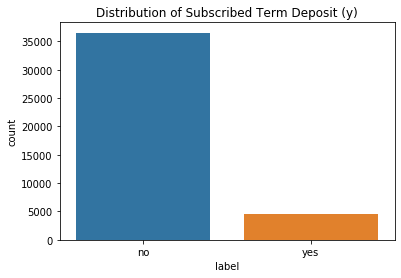

In [30]:

# Countplot of the target variable
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=df_final_pandas)
plt.title('Distribution of Subscribed Term Deposit (y)')
plt.show()

##### What is the distribution of age among the clients?

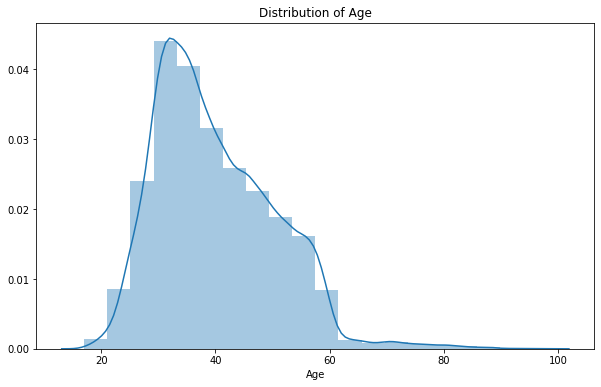

In [31]:
plt.figure(figsize=(10, 6))
sns.distplot(df_final_pandas['age'], bins=20, kde=True)
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.show()


##### How are job categories distributed?

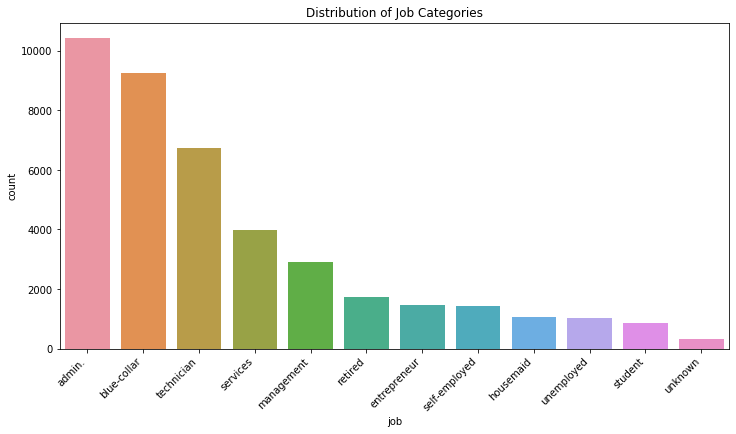

In [32]:
plt.figure(figsize=(12, 6))
sns.countplot(x='job', data=df_final_pandas, order=df_final_pandas['job'].value_counts().index)
plt.title('Distribution of Job Categories')
plt.xticks(rotation=45, ha='right')
plt.show()


##### What is the distribution of marital status among clients?

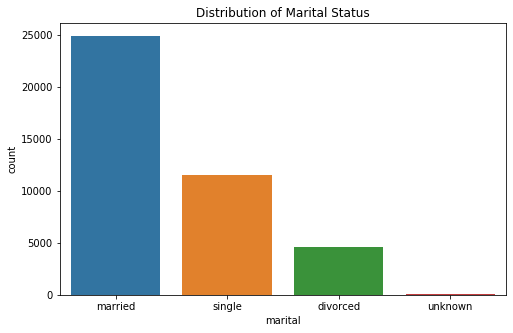

In [33]:
plt.figure(figsize=(8, 5))
sns.countplot(x='marital', data=df_final_pandas, order=df_final_pandas['marital'].value_counts().index)
plt.title('Distribution of Marital Status')
plt.show()


##### What is the distribution of education levels among clients?

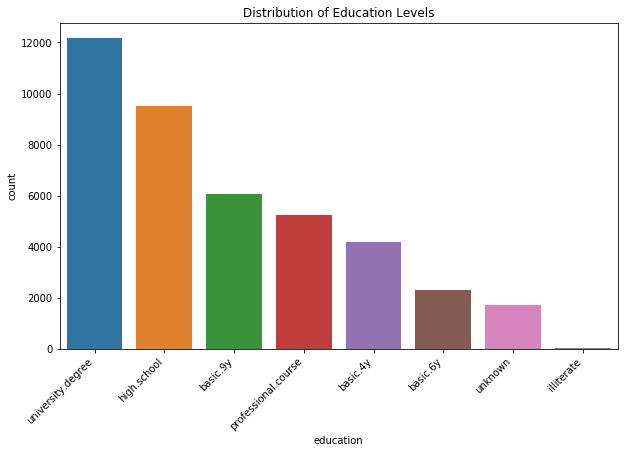

In [34]:
plt.figure(figsize=(10, 6))
sns.countplot(x='education', data=df_final_pandas, order=df_final_pandas['education'].value_counts().index)
plt.title('Distribution of Education Levels')
plt.xticks(rotation=45, ha='right')
plt.show()


##### How many clients have credit in default?

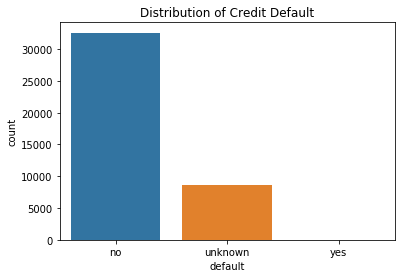

In [35]:
plt.figure(figsize=(6, 4))
sns.countplot(x='default', data=df_final_pandas)
plt.title('Distribution of Credit Default')
plt.show()


##### How does the distribution of campaign durations vary across different job categories?

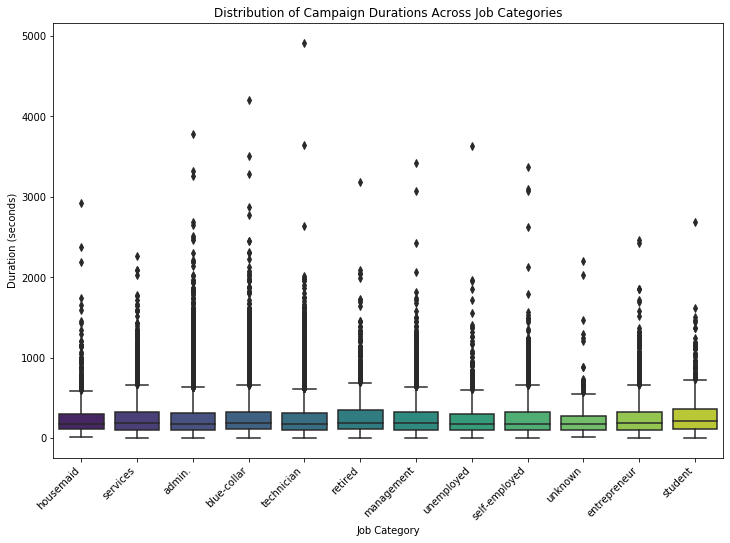

In [36]:
# Plotting the distribution of campaign durations for different job categories
plt.figure(figsize=(12, 8))
sns.boxplot(x='job', y='duration', data=df_final_pandas, palette='viridis')
plt.title('Distribution of Campaign Durations Across Job Categories')
plt.xlabel('Job Category')
plt.ylabel('Duration (seconds)')
plt.xticks(rotation=45, ha='right')
plt.show()


In [37]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [38]:
# Create a Spark session
spark = SparkSession.builder.appName("DecisionTreeClassification").getOrCreate()

In [39]:
df = spark.createDataFrame(df_final_pandas)

In [40]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Split the data into training and test sets
(train_data, test_data) = df.randomSplit([0.8, 0.2], seed=42)



In [41]:
df.select("features","label").show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(14,[0,1,2,3,5,7,...|   no|
|[57.0,149.0,1.0,9...|   no|
|(14,[0,1,2,3,5,7,...|   no|
|(14,[0,1,2,3,7,9,...|   no|
|[56.0,307.0,1.0,9...|   no|
+--------------------+-----+
only showing top 5 rows



In [42]:
df.printSchema()

root
 |-- age: long (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- duration: long (nullable = true)
 |-- campaign: long (nullable = true)
 |-- pdays: long (nullable = true)
 |-- previous: long (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- emp_var_rate: string (nullable = true)
 |-- cons_price_idx: string (nullable = true)
 |-- cons_conf_idx: string (nullable = true)
 |-- euribor3m: string (nullable = true)
 |-- nr_employed: string (nullable = true)
 |-- label: string (nullable = true)
 |-- job_index: double (nullable = true)
 |-- marital_index: double (nullable = true)
 |-- education_index: double (nullable = true)
 |-- default_index: double (nullable

In [43]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.types import DoubleType 
#df = df.withColumn("label", df["label"].cast(DoubleType()))

In [44]:
# Split the data into training and test sets
(train_data, test_data) = df.randomSplit([0.8, 0.2], seed=42)

# Create a Decision Tree classifier
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")

In [45]:
# Display the number of rows in the training and test datasets
print("Number of rows in the training dataset:", train_data.count())
print("Number of rows in the test dataset:", test_data.count())

Number of rows in the training dataset: 33072
Number of rows in the test dataset: 8116


In [46]:
df.select("label").show(5)

+-----+
|label|
+-----+
|   no|
|   no|
|   no|
|   no|
|   no|
+-----+
only showing top 5 rows



In [47]:
from pyspark.sql.functions import col, when
df = df.withColumn("label", when(col("label") == "yes", 1).otherwise(0))
df = df.withColumn("label", df["label"].cast("integer"))
#df = indexer.fit(df).transform(df)
#dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")
df.printSchema()
df.show()

root
 |-- age: long (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- duration: long (nullable = true)
 |-- campaign: long (nullable = true)
 |-- pdays: long (nullable = true)
 |-- previous: long (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- emp_var_rate: string (nullable = true)
 |-- cons_price_idx: string (nullable = true)
 |-- cons_conf_idx: string (nullable = true)
 |-- euribor3m: string (nullable = true)
 |-- nr_employed: string (nullable = true)
 |-- label: integer (nullable = false)
 |-- job_index: double (nullable = true)
 |-- marital_index: double (nullable = true)
 |-- education_index: double (nullable = true)
 |-- default_index: double (nullab

In [48]:
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")

In [49]:
from pyspark.ml.feature import StringIndexer

# Assuming your label column is named 'label'
indexer = StringIndexer(inputCol="label", outputCol="indexedLabel")
indexed_data = indexer.fit(train_data).transform(train_data)
indexed_test_data = indexer.fit(test_data).transform(test_data)

In [50]:
from pyspark.ml.classification import DecisionTreeClassifier

# Assuming 'features' is the feature vector column
dt = DecisionTreeClassifier(featuresCol="features", labelCol="indexedLabel", maxDepth=5)

# Continue with your pipeline or model fitting
model = dt.fit(indexed_data)

In [51]:
from pyspark.sql import SparkSession
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline

predictions = model.transform(indexed_test_data)

In [52]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print(f"Accuracy: {accuracy}")

Accuracy: 0.9103006407097092


In [53]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="f1")
f1_score = evaluator.evaluate(predictions)

print(f"F1-Score: {f1_score}")

F1-Score: 0.9035971103351403
